ПРОЦЕСС РАБОТЫ СО STREAMLIT

Шаг 1. Бекэнд. Создадим файл app.py.

Импортируем библиотеки для работы с данными. Ничего особенного, все библиотеки должны быть вам знакомы.

In [ ]:
import streamlit as st
import numpy as np
import pandas as pd
import lightfm as lf
import nmslib
import pickle
import scipy.sparse as sparse

Пропишем вспомогательные функции: 

In [ ]:
def nearest_books_nms(book_id, index, n=10):
    """Функция для поиска ближайших соседей, возвращает построенный индекс"""
    nn = index.knnQuery(item_embeddings[book_id], k=n)
    return nn

Первая функция использует наш построенный index для поиска книг. Думайте об этой функции как о реализации K-NN (k-ближайших соседей). 

Функция get_names просто возвращает список книг,  а точнее их названия, в виде [(Название книги, Имя Автора),...]:

In [ ]:
def get_names(index):
    """
    input - idx of books
    Функция для возвращения имени книг
    return - list of names
    """
    names = []
    for idx in index:
        names.append('Book name:  {} '.format(
            name_mapper[idx]) + '  Book Author: {}'.format(author_mapper[idx]))
    return names

Чтение файлов никогда не было таким увлекательным!

In [ ]:
def read_files(folder_name='data'):
    """
    Функция для чтения файлов + преобразование к  нижнему регистру
    """
    ratings = pd.read_csv(folder_name+'/ratings.csv')
    books = pd.read_csv(folder_name+'/books.csv')
    books['title'] = books.title.str.lower()
    return ratings, books 

Снова создадим словари, чтобы получить возможность сопоставлять элементы из разных таблиц.

In [ ]:
def make_mappers():
    """
    Функция для создания отображения id в title
    """
    name_mapper = dict(zip(books.id, books.title))
    author_mapper = dict(zip(books.id, books.authors))

    return name_mapper, author_mapper

Давайте загрузим векторные представления книг, которые мы сохранили в предыдущем модуле.

In [ ]:
def load_embeddings():
    """
    Функция для загрузки векторных представлений
    """
    with open('item_embeddings.pickle', 'rb') as f:
        item_embeddings = pickle.load(f)

    # Тут мы используем nmslib, чтобы создать наш быстрый knn
    nms_idx = nmslib.init(method='hnsw', space='cosinesimil')
    nms_idx.addDataPointBatch(item_embeddings)
    nms_idx.createIndex(print_progress=True)
    return item_embeddings,nms_idx

А теперь выполним весь код, который мы написали.

In [ ]:
#Загружаем данные
ratings, books  = read_files(folder_name='data') 
name_mapper, author_mapper = make_mappers()
item_embeddings,nms_idx = load_embeddings()

Сохраним наш код.

Шаг 2. Streamlit

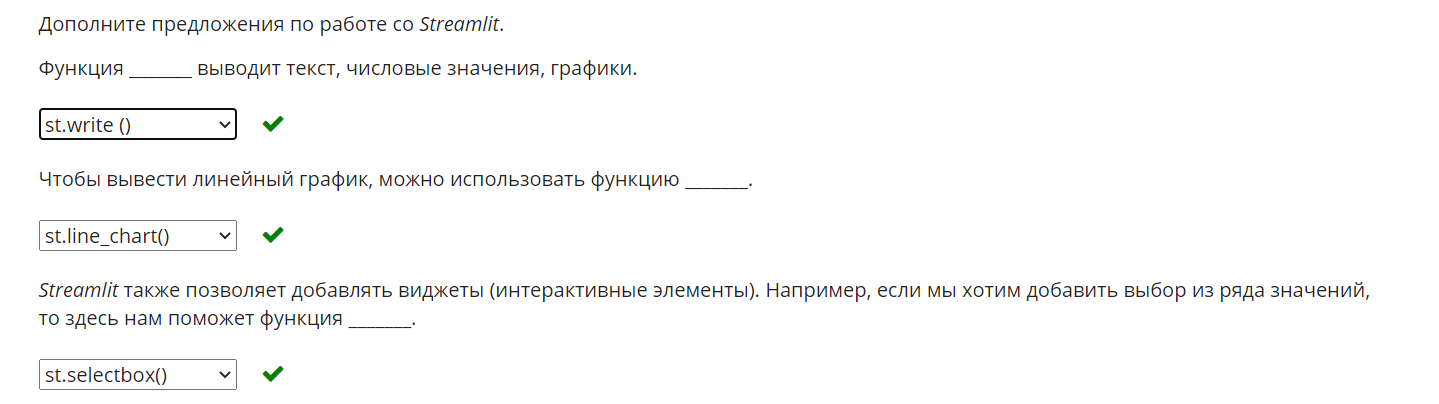

Установим библиотеку Streamlit с помощью команды pip в командной строке:

In [ ]:
pip install streamlit

Запустим наш файл его из командной строки с помощью команды:

In [ ]:
streamlit run app.py

Получаем следующее сообщение:

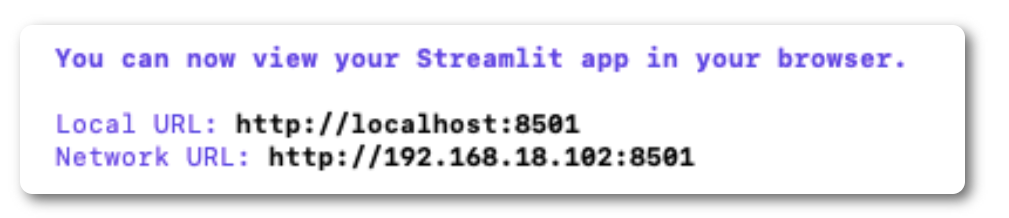

Если мы перейдем по ссылке http://localhost:8501, то увидим пустой экран. Это нормально, ведь мы ещё не передали Streamlit ни одной команды.

На наше счастье, Streamlit позволяет моментально отслеживать любые внесённые изменения. Для этого достаточно вызвать команду Rerun в правом верхнем углу экрана. 

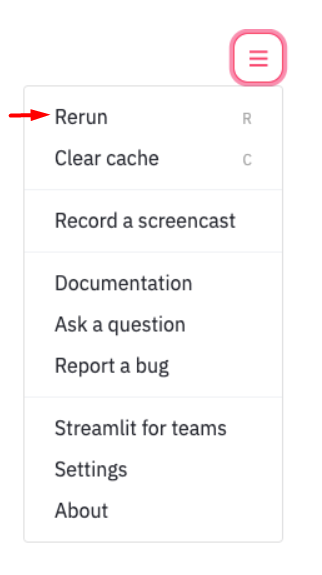

По мере выполнения следующих шагов мы рекомендуем вам периодически перезапускать код, чтобы лучше понять принцип работы с библиотекой.

Итак, приступим к написанию приложения!

ПИШЕМ ПРИЛОЖЕНИЕ

Создадим приветственную форму (нет, не helloworld). Просто попросим пользователя ввести название книги.

In [ ]:
#Форма для ввода текста
title = st.text_input('Book Name', '')
title = title.lower()

Найдём в наших данных книгу, используя pandas.

In [ ]:
#Наш поиск по книгам
output = books[books.title.str.contains(title) > 0]

Используем Streamlit, чтобы выбрать книгу из списка, и выводим её название.

In [ ]:
#Выбор книги из списка
option = st.selectbox('Which book?', output['title'].values)

#Выводим книгу
'You selected: ', option

Найдём рекомендации к книге с помощью функции nearest_books_nms.

In [ ]:
#Ищем рекомендации
val_index = output[output['title'].values == option].id
index = nearest_books_nms(val_index, nms_idx, 5)

И снова, пользуясь магией Streamlit, выводим книгу:

In [ ]:
#Выводим рекомендации к ней
'Most simmilar books are: '
st.write('', get_names(index[0])[1:])

Барабанная дробь! Прототип готов!

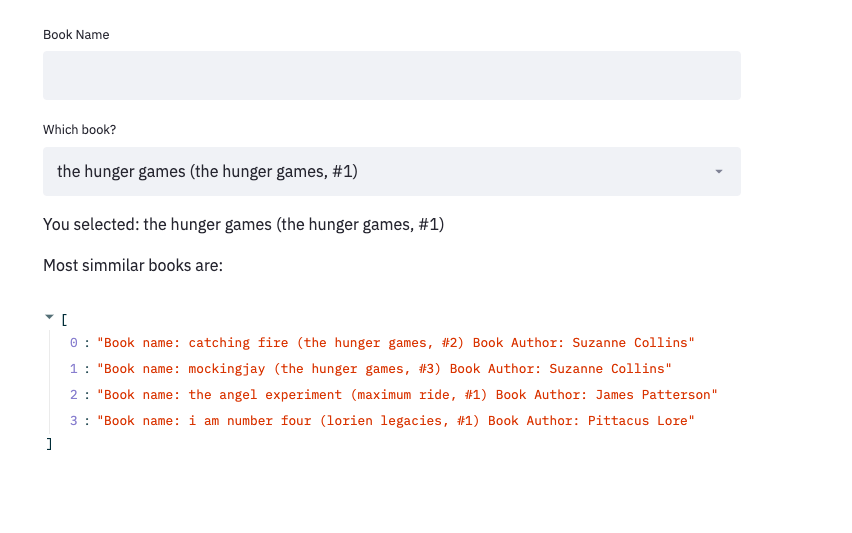

ПОЛЕЗНЫЕ ССЫЛКИ ПО STREAMLIT

- Основная документация по работе с библиотекой (англ.) https://docs.streamlit.io/
- Зачем работать со Streamlit? (англ.) https://towardsdatascience.com/coding-ml-tools-like-you-code-ml-models-ddba3357eace
- Пример приложения от Airbnb NYC на Streamlit (англ.) https://towardsdatascience.com/streamlit-101-an-in-depth-introduction-fc8aad9492f2

Heroku: регистрация

Что такое Heroku?

Heroku — это, формально говоря, PaaS (Platform as a Service, платформа как сервис). Другими словами, это сервис, который позволяет очень быстро разворачивать наши приложения в облаке. 

Давайте попробуем развернуть наше рекомендательную систему на Heroku!

РЕГИСТРАЦИЯ НА HEROKU 

Для начала зарегистрируйтесь по ссылке: https://signup.heroku.com/identity

Установите Heroku, скачав его по ссылке: https://devcenter.heroku.com/articles/getting-started-with-python#set-up

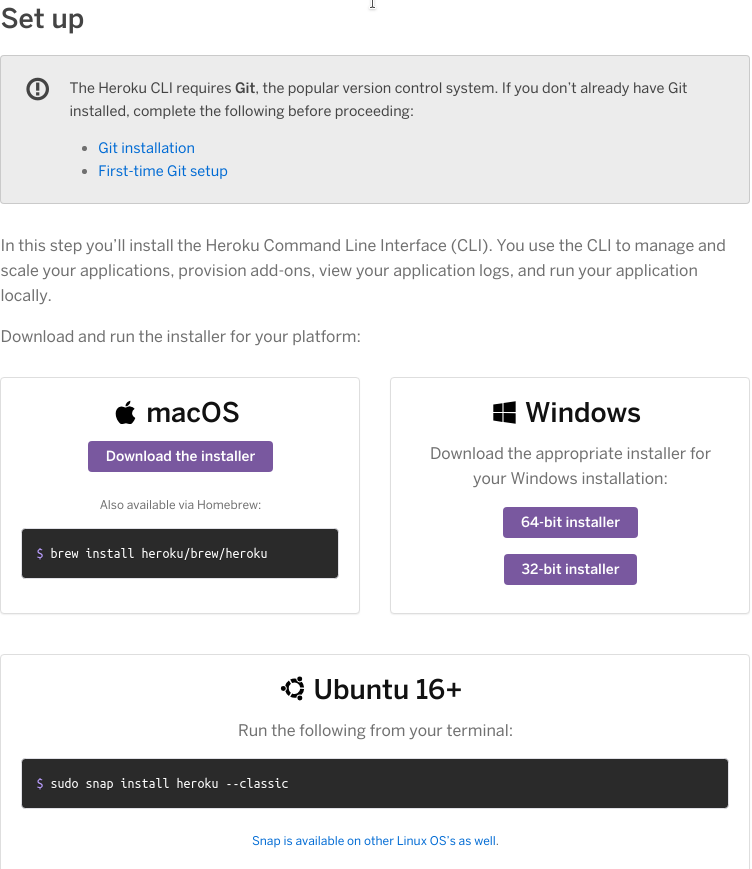

Зайдём в Heroku из нашей командной строки:

heroku login

heroku: Press any key to open up the browser to login or q to exit

 ›   Warning: If browser does not open, visit

 ›   https://cli-auth.heroku.com/auth/browser/***

В браузере увидим следующую картину:

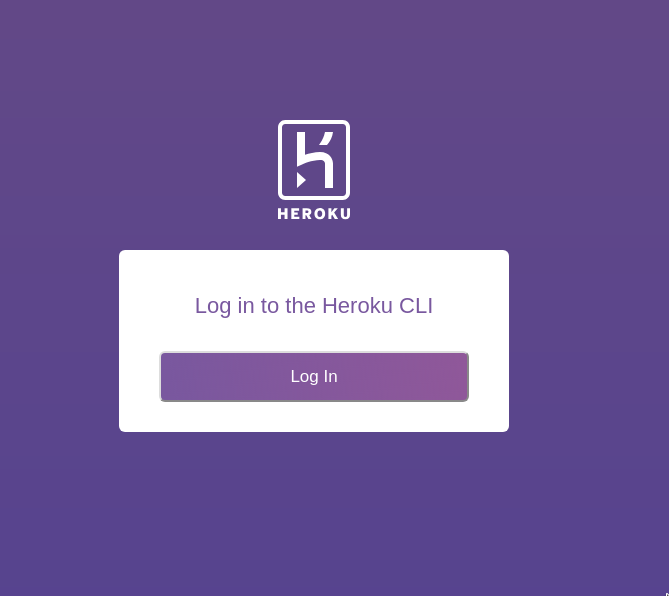

Нажмём Log In, и в консоли появится:

Logging in... done

Logged in as skillfactorystudent@gmail.com """тот e-mail, на который вы зарегистрировались"""

Создание приложения для деплоя

На компьютере создадим папку heroku_deploy и дополним её следующими файлами: 

requirements.txt

Список библиотек, которые будут использоваться Python. Их нужно будет установить на сервере. В нашем случае внутри requirements.txt мы напишем:

streamlit==0.49.0

pandas==0.23.4

lightfm==1.15

nmslib==2.0.5

scipy==1.1.0

setup.sh

Это файл, который запустится при создании виртуальной машины на Heroku. В нём мы указываем настройки для Streamlit.

mkdir -p ~/.streamlit/

echo "\

[general]\n\

email = \"your-email@domain.com\"\n\

" > ~/.streamlit/credentials.toml

echo "\

[server]\n\

headless = true\n\

enableCORS=false\n\

port = $PORT\n\

" > ~/.streamlit/config.toml

Procfile

Это файл, который будет запущен сразу при создании виртуальной машины на Heroku. Он в свою очередь запустит setup.sh и streamlit.

web: sh setup.sh && streamlit run app.py
Кроме этого, мы должны поместить в папку файлы, которые мы создали в предыдущем модуле:

app.py, item_embeddings.pickle """и папку data с нашими книгами"""
Теперь выполним команду git init и создадим репозиторий.

Initialized empty Git repository in heroku_deploy/.git/
Создадим приложение в облаке:

heroku create

Creating app... done, rocky-reaches-88613
Теперь загрузим наше приложение в облако:

git add .

git commit -m "first version of recommender system"

git push heroku master
И проверяем:

remote: Verifying deploy... done.

To https://git.heroku.com/rocky-reaches-88613.git

https://rocky-reaches-88613.herokuapp.com/
Всё работает!

ПОЛЕЗНЫЕ ССЫЛКИ

- Пошаговая инструкция по работе с Heroku: https://devcenter.heroku.com/articles/getting-started-with-python#set-up
- Инструкция по созданию дашборда Streamlit + Heroku (англ.): https://towardsdatascience.com/quickly-build-and-deploy-an-application-with-streamlit-988ca08c7e83
- Код, использованный в модуле, можно скачать здесь: https://lms.skillfactory.ru/assets/courseware/v1/bbe09a1d53ea8c8e01b51a96320df736/asset-v1:Skillfactory+DST-10+22JAN2020+type@asset+block/app.py